Let's start by installing the relevant libraries.

In [1]:
!pip install -q transformers datasets

In [21]:
from datasets import load_dataset

# Sừ dụng dataset Cifar10 gồm 10 class
train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])
# splits = train_ds.train_test_split(test_size=0.1)
# train_ds = splits['train']
# val_ds = splits['test']

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [4]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

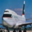

In [5]:
train_ds[0]['img']

In [6]:
train_ds[0]['label']

0

In [22]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
id2label[train_ds[0]['label']]

'airplane'

In [9]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

2024-03-27 12:09:52.942732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 12:09:52.942836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 12:09:53.122358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [23]:
# Set the transforms
train_ds.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [12]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [0, 8],
 'pixel_values': [tensor([[[-0.6863, -0.6863, -0.6863,  ..., -0.7255, -0.7255, -0.7255],
           [-0.6863, -0.6863, -0.6863,  ..., -0.7255, -0.7255, -0.7255],
           [-0.6863, -0.6863, -0.6863,  ..., -0.7255, -0.7255, -0.7255],
           ...,
           [-0.4353, -0.4353, -0.4353,  ..., -0.6314, -0.6314, -0.6314],
           [-0.4353, -0.4353, -0.4353,  ..., -0.6314, -0.6314, -0.6314],
           [-0.4353, -0.4353, -0.4353,  ..., -0.6314, -0.6314, -0.6314]],
  
          [[-0.1216, -0.1216, -0.1216,  ..., -0.1686, -0.1686, -0.1686],
           [-0.1216, -0.1216, -0.1216,  ..., -0.1686, -0.1686, -0.1686],
           [-0.1216, -0.1216, -0.1216,  ..., -0.1686, -0.1686, -0.1686],
           ...,
           [-0.1922, -0.1922, -0.1922,  ..., -0.1686, -0.1686, -0.1686],
           [-0.1922, -0.1922, -0.1922,  ..., -0.1686, -0.1686, -0.

In [27]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=128)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([512, 3, 224, 224])
labels torch.Size([512])


In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=20,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    remove_unused_columns=False,
)

In [17]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [29]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [30]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.278400,0.042467,0.989600
2,0.221500,0.027912,0.994000
3,0.184900,0.020741,0.996600


***** train metrics *****
  epoch                    =           3.0
  total_flos               = 10826282096GF
  train_loss               =        0.2197
  train_runtime            =    0:52:04.78
  train_samples_per_second =        48.003
  train_steps_per_second   =           2.4


In [32]:
outputs = trainer.predict(test_ds)

In [34]:
print(outputs.metrics)

{'test_loss': 0.04733216390013695, 'test_accuracy': 0.9878, 'test_runtime': 80.1922, 'test_samples_per_second': 124.7, 'test_steps_per_second': 15.588}


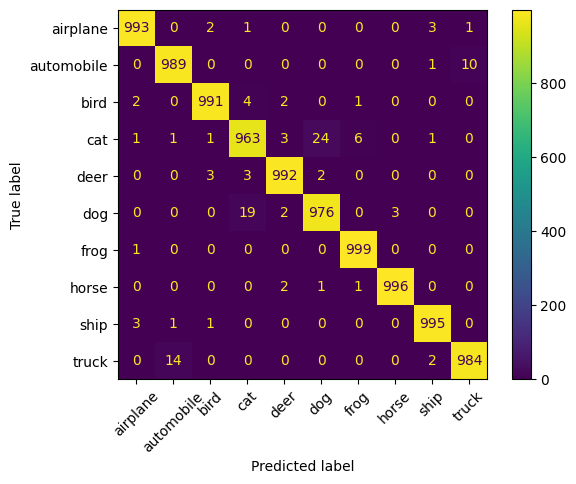

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)